# Online Shoppers Intent  
Aleksandar Gakovic & Sezgin Isguzar

---

## Table of Contents:



1. **Executive Summary**  
2. **Import Data**  
3. **Data Cleaning**  
4. **Data Exploration**  
    4.1 Dataset Information  
    4.2 Feature Information  
    4.3 Screening for Categorical Variables
5. **Baseline Model**  
    5.1 Split and transform the training and test data  
    5.2 Decision tree model  
6. **Exploring Improvements on Baseline Model**  
    6.1 Grid Search CV for Decision tree with Entropy impurity  
    6.2 Logistic Regression Classifier  
    6.3 Ensemble Methods - Random Forests  
    6.4 Feature Importances  
7. **Threshold Selection** 
8. **Testing our Model** 
9. **Conclusions**  
10. **Recommendations**
    
    



## 1. Executive Summary
We are assuming the position of Data Scientists at DataScienceDeals.com a company that sells courses on Data Science. We have data related to the visitors that come to our site. The data is related to time spent on the site and on which kind of page, proximity to a special event day etc.

The objective of this project is to predict which visitors are likely to produce revenue. This will feed into our new 1:1 chat help service feature that will be able to guide potential customers to a purchase.


## 2. Import Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from textwrap import wrap
%matplotlib inline

#Preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

#sklearn model selection:
from sklearn.model_selection import KFold, train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_predict
              
# sklearn tree module
from sklearn.tree import DecisionTreeClassifier 
from sklearn.tree import export_graphviz

# sklearn metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, precision_recall_curve
from sklearn.metrics import plot_confusion_matrix

#Other sklearn modules:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

#Import Ipython library 
from IPython.display import Image  
from pydotplus import graph_from_dot_data

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('online_shoppers_intention.csv')
df.shape

(12330, 18)

In [5]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


## 3. Data cleaning

In [3]:
df.isna().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

In [4]:
df.duplicated().sum()

125

Our Data Looks pretty clean without any nulls and very small number of duplicates which are highly likely to be by chance.

## 4. Exploration

### 4.1 Data Set Information:

The dataset consists of feature vectors belonging to 12,330 sessions. The dataset was formed so that each session would belong to a different user in a 1-year period to avoid any tendency to a specific campaign, special day, user profile, or period.

### 4.2 Attribute Information:

The dataset consists of 10 numerical and 8 categorical attributes. The 'Revenue' attribute can be used as the class label.
"Administrative", "Administrative Duration", "Informational", "Informational Duration", "Product Related" and "Product Related Duration" represent the number of different types of pages visited by the visitor in that session and total time spent in each of these page categories. The values of these features are derived from the URL information of the pages visited by the user and updated in real time when a user takes an action, e.g. moving from one page to another. The "Bounce Rate", "Exit Rate" and "Page Value" features represent the metrics measured by "Google Analytics" for each page in the e-commerce site. The value of "Bounce Rate" feature for a web page refers to the percentage of visitors who enter the site from that page and then leave ("bounce") without triggering any other requests to the analytics server during that session. The value of "Exit Rate" feature for a specific web page is calculated as for all pageviews to the page, the percentage that were the last in the session. The "Page Value" feature represents the average value for a web page that a user visited before completing an e-commerce transaction. The "Special Day" feature indicates the closeness of the site visiting time to a specific special day (e.g. Mother’s Day, Valentine's Day) in which the sessions are more likely to be finalized with transaction. The value of this attribute is determined by considering the dynamics of e-commerce such as the duration between the order date and delivery date. For example, for Valentina’s day, this value takes a nonzero value between February 2 and February 12, zero before and after this date unless it is close to another special day, and its maximum value of 1 on February 8. The dataset also includes operating system, browser, region, traffic type, visitor type as returning or new visitor, a Boolean value indicating whether the date of the visit is weekend, and month of the year.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [6]:
df.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157213,0.016813,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


## 4.3 Screen for Categorical variables:

In [8]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [7]:
df.nunique()

Administrative               27
Administrative_Duration    3335
Informational                17
Informational_Duration     1258
ProductRelated              311
ProductRelated_Duration    9551
BounceRates                1872
ExitRates                  4777
PageValues                 2704
SpecialDay                    6
Month                        10
OperatingSystems              8
Browser                      13
Region                        9
TrafficType                  20
VisitorType                   3
Weekend                       2
Revenue                       2
dtype: int64

In [10]:
# Here we are checking the ratio of unique values to the total number count for each column
screen_series = df.nunique()/df.count()
type(screen_series)
screen_series[screen_series < 0.05]
# proportions of nuniques to total counts < 0.05 *suggest* categorical variables

Administrative      0.002190
Informational       0.001379
ProductRelated      0.025223
SpecialDay          0.000487
Month               0.000811
OperatingSystems    0.000649
Browser             0.001054
Region              0.000730
TrafficType         0.001622
VisitorType         0.000243
Weekend             0.000162
Revenue             0.000162
dtype: float64

Administrative, Informational and ProductRelated are the number of types of these pages a visitor has visited during their session. Therefore are calssed as continuous.

In [11]:
# Subset categorical and continuous features from dataframe for visualisations:
df_cont = df[['Administrative','Administrative_Duration','Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'ExitRates', 'PageValues', 'BounceRates']]
df_cat = df.drop(df_cont.columns, axis=1)

### 4.4 Pairwise Associations of Predictor Variables 


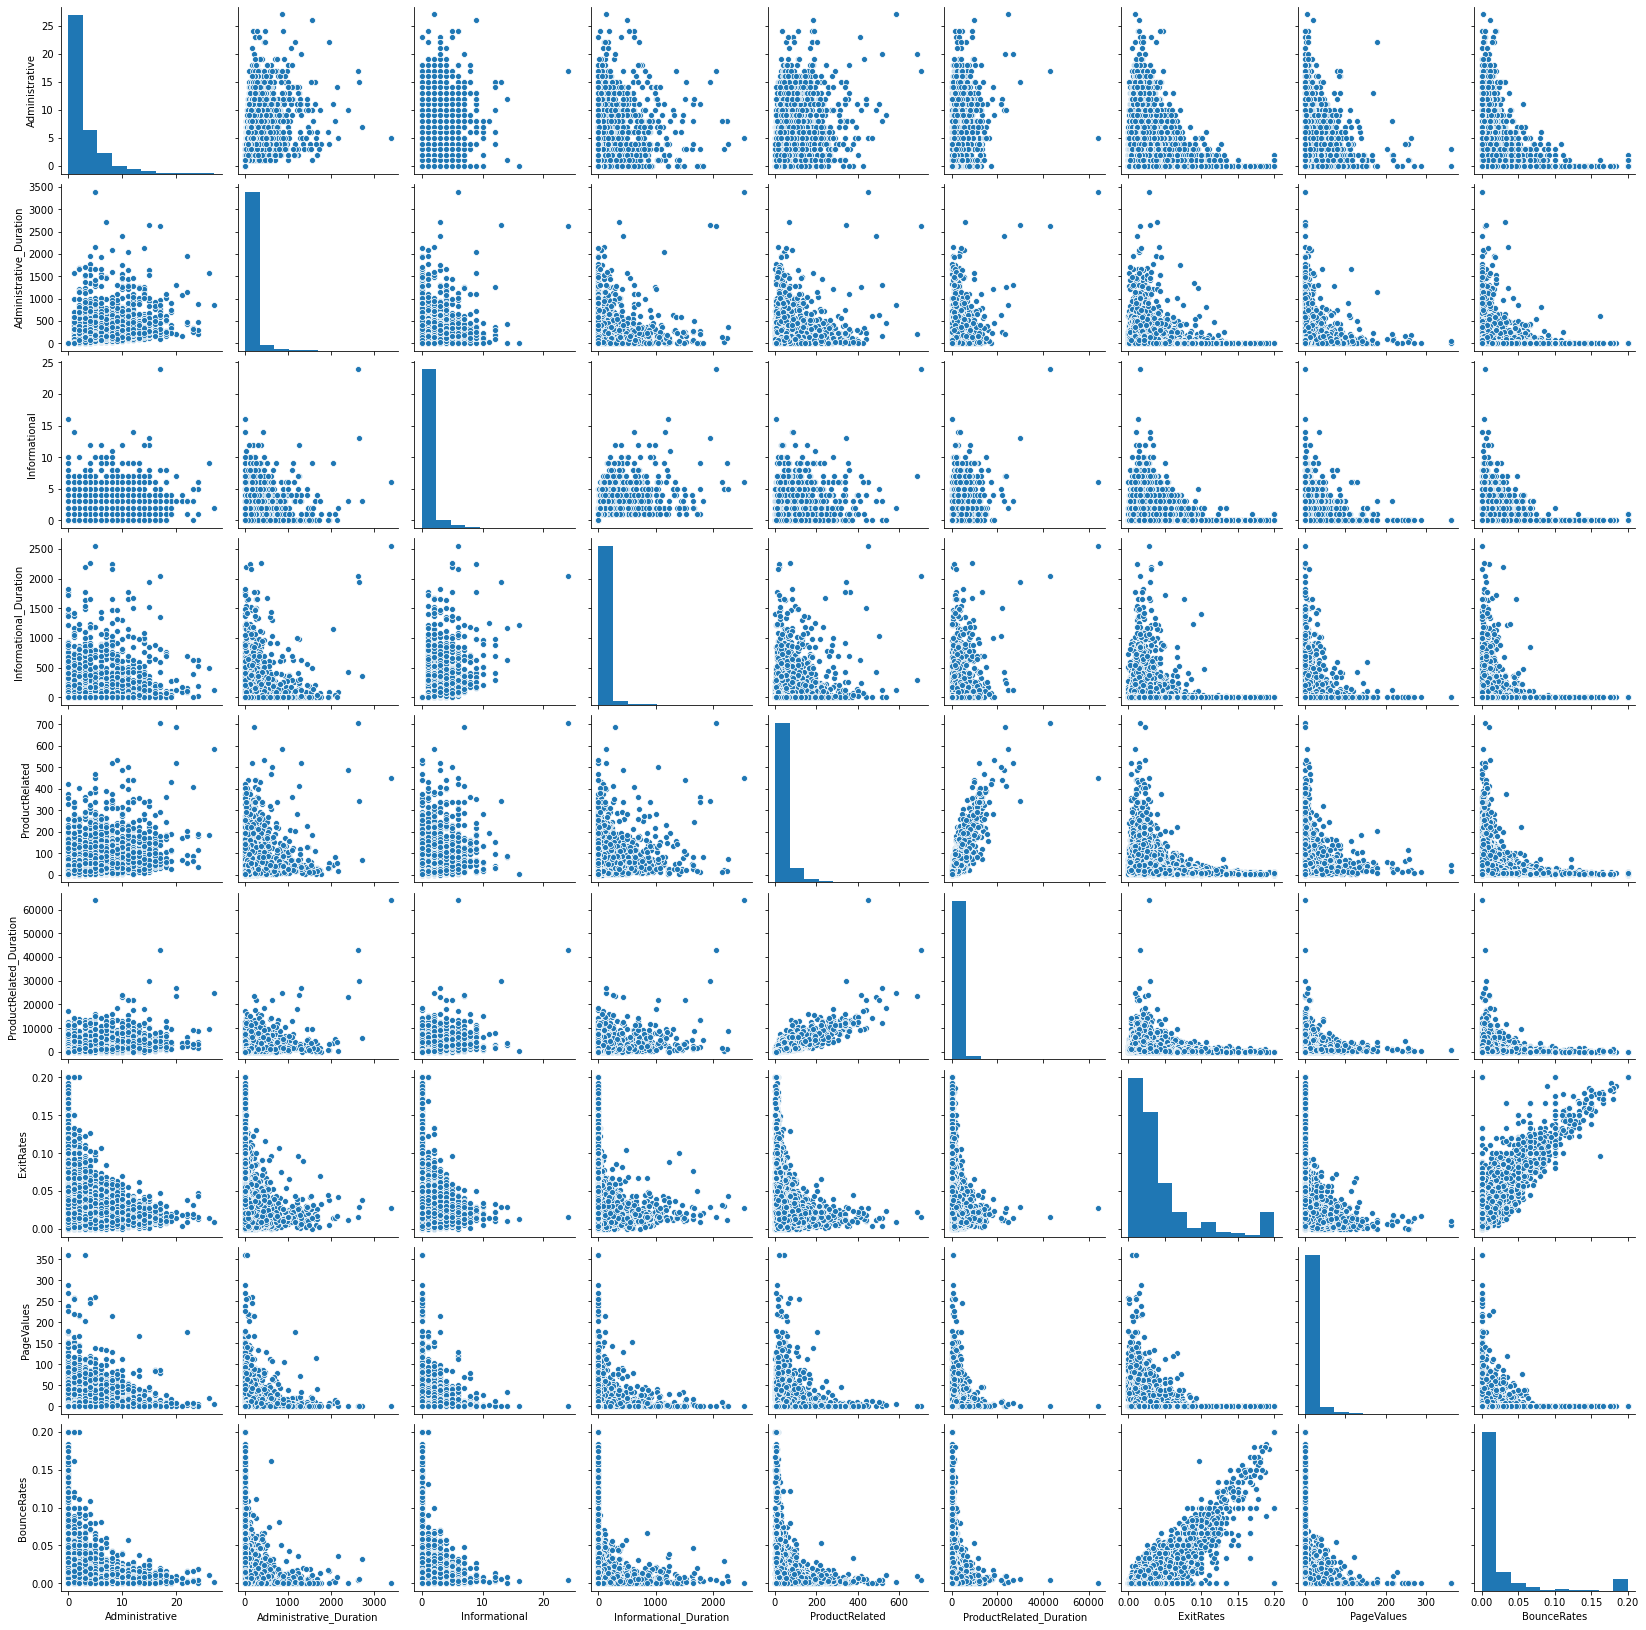

In [12]:
#Continuous predictor vairables:
sns.pairplot(data=df_cont)

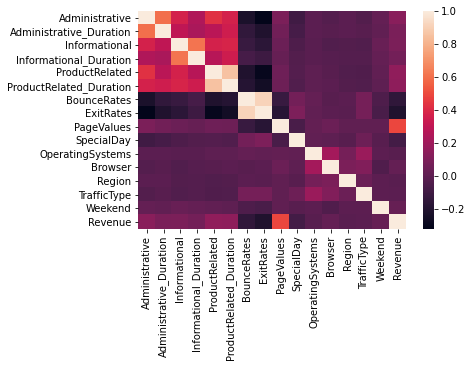

In [13]:
# Heatmap of correlations of all variables
corr = df.corr()
sns.heatmap(corr)

In [14]:
unstacked_corr_df = corr.unstack()
sorted_series = unstacked_corr_df.sort_values(kind="quicksort")

# obtain high correlation features:
sorted_series[(sorted_series > 0.8) & (sorted_series < 1)]

ProductRelated_Duration  ProductRelated             0.860927
ProductRelated           ProductRelated_Duration    0.860927
ExitRates                BounceRates                0.913004
BounceRates              ExitRates                  0.913004
dtype: float64

correlations for consideration:

- productRelated duration - productRelated  
- bounceRates - Exit rates

## 5. Baseline Model

### 5.1 Split and transform the training and test data

In [16]:
# Feature and Target subsetting:
X = df.drop(columns=['Revenue'], axis =1)
y = df['Revenue']

In [21]:
# One-hot encode the categorical variables in the training data and show the resulting DataFrame with proper column names
ohe = OneHotEncoder()

# subset continuous and categorical variables:
X_cont = X[['Administrative','Administrative_Duration','Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'ExitRates', 'PageValues', 'BounceRates']]
X_cat = X.drop(X_cont.columns, axis=1)

#Fit transform the variables and place them in a dataframe
encoded_vars = ohe.fit_transform(X_cat).toarray()
ohe_X_cat = pd.DataFrame(encoded_vars, columns=ohe.get_feature_names(X_cat.columns))
print(ohe_X_cat.shape)

scaler = StandardScaler()
scaled_X_cont = pd.DataFrame(scaler.fit_transform(X_cont), columns= X_cont.columns)
print(scaled_X_cont.shape)

(12330, 71)
(12330, 9)


In [28]:
# # reset index and make a copy of continuous dataframe.
# X_cont_copy = X_cont.copy()
# X_cont_copy.reset_index(drop=True, inplace=True)

# Concatenate transformed dataframes into one predictor variable dataframe X:
X = pd.concat([scaled_X_cont, ohe_X_cat], axis=1)
X.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,ExitRates,PageValues,BounceRates,SpecialDay_0.0,...,TrafficType_16,TrafficType_17,TrafficType_18,TrafficType_19,TrafficType_20,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor,Weekend_False,Weekend_True
0,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,3.229316,-0.317178,3.667189,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.590903,1.171473,-0.317178,-0.457683,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,3.229316,-0.317178,3.667189,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.622954,1.994610,-0.317178,0.573535,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,-0.696993,-0.457191,-0.396478,-0.244931,-0.488636,-0.296430,0.142551,-0.317178,-0.045196,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [15]:
#train_test_split and create a global seed
seed=42
X_train, X_test, y_train, y_test = train_test_split(final_df, y, test_size=0.20, random_state = seed)

In [16]:
# #train_test_split again to create train and validation 

# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state = seed)

### 5.2 Decision Tree fit and evaluation

In [17]:
# Decision tree classifier fit 
clf = DecisionTreeClassifier(random_state = seed, criterion='entropy')

clf.fit(X_train, y_train)

#KFold cross validator instantiated:
cv = KFold(n_splits=5, random_state=seed)

# Use Crossvalidation to obtain Performance metrics: F1 Score and Accuracy
F1_score = round(np.mean(cross_val_score(clf, X_train, y_train, cv=cv, scoring='f1')), 4)
Acc_score = round(np.mean(cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy')), 4)
roc_AUC_score = round(np.mean(cross_val_score(clf, X_train, y_train, cv=cv, scoring='roc_auc')), 4)
#Print F1 and Accuracy and ROC_AUC score for crossvalidation baseline decision tree
F1_score, Acc_score, roc_AUC_score

(0.5552, 0.8651, 0.7381)

## 6.0 Exploring Improvements on Baseline Model

In [25]:
# Gini impurity Decision tree classifier fit 
clf1 = DecisionTreeClassifier(random_state = seed, criterion='gini')
clf1.fit(X_train, y_train)

# Use Crossvalidation to obtain Performance metrics: F1 Score and Accuracy
F1_score = round(np.mean(cross_val_score(clf1, X_train, y_train, cv=cv, scoring='f1')), 4)
Acc_score = round(np.mean(cross_val_score(clf1, X_train, y_train, cv=cv, scoring='accuracy')), 4)
roc_AUC_score = round(np.mean(cross_val_score(clf1, X_train, y_train, cv=cv, scoring='roc_auc')), 4)

#Print F1 and Accuracy and ROC_AUC score for crossvalidation baseline decision tree
F1_score, Acc_score, roc_AUC_score

(0.5659, 0.8694, 0.7428)

### 6.1 Grid Search CV for Decision tree with Entropy impurity

In [26]:
# Entropy criterion performed better. Let's implement hyperparameter tuning with combinatoric grid searching.

#initial Param grid:

dt_param_grid = {
    'criterion': ['entropy'],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [10, 500, 1000]
}


#insantiate the GridSearchCV
dt_grid_search = GridSearchCV(clf, dt_param_grid, cv=3, return_train_score=True)

# Fit to the data
dt_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=DecisionTreeClassifier(criterion='entropy',
                                              random_state=42),
             param_grid={'criterion': ['entropy'],
                         'max_depth': [None, 2, 3, 4, 5, 6],
                         'min_samples_split': [10, 500, 1000]},
             return_train_score=True)

In [27]:
# Mean training score
dt_gs_training_score = np.mean(dt_grid_search.cv_results_['mean_train_score'])


print(f"Mean Training Score: {dt_gs_training_score :.2%}")

# Print best parameter combination found during grid search:
print("Best Parameter Combination Found During Grid Search:")
dt_grid_search.best_params_

Mean Training Score: 90.32%
Best Parameter Combination Found During Grid Search:


{'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 10}

In [28]:
# Primary Param grid prediction scores: (Accuracy, Precision, Recall and F1)
predictions = dt_grid_search.best_estimator_.predict(X_train)
accuracy_score1 = accuracy_score(y_train, predictions)
recall_score1 = recall_score(y_train, predictions)
precision_score1 = precision_score(y_train, predictions)
F1_score1 = f1_score(y_train, predictions)
print(f'Recall Score:{recall_score1}\nPrecision Score:{precision_score1}\nAccuracy Score{accuracy_score1}\nF1 Score {F1_score1}')

Recall Score:0.6239144956579826
Precision Score:0.6949404761904762
Accuracy Score0.9013584752635847
F1 Score 0.6575149595212954


In [25]:
# Secondary Param_Grid:

dt_param_grid1 = {
    'criterion': ['entropy'],
    'max_depth': [3],
    'min_samples_split': [2,3,5,7,9]
}
dt_grid_search1 = GridSearchCV(clf, dt_param_grid1, cv=3, return_train_score=True)

# Fit to the data
dt_grid_search1.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=DecisionTreeClassifier(criterion='entropy',
                                              random_state=42),
             param_grid={'criterion': ['entropy'], 'max_depth': [3],
                         'min_samples_split': [2, 3, 5, 7, 9]},
             return_train_score=True)

In [26]:
# Secondary Param Grid Mean train score 
dt_gs_training_score1 = np.mean(dt_grid_search1.cv_results_['mean_train_score'])

print(f"Mean Training Score: {dt_gs_training_score1 :.2%}")

# Secondary Param grid best combinations:
print("Best Parameter Combination Found During Grid Search:")
dt_grid_search1.best_params_

Mean Training Score: 90.04%
Best Parameter Combination Found During Grid Search:


{'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2}

In [27]:
#Predictions for secondary parameter grid and its related Recall, precision accuracy and F1 scores:
predictions = dt_grid_search1.best_estimator_.predict(X_train)
acc_score = accuracy_score(y_train, predictions)
rec_score = recall_score(y_train, predictions)
prec_score = precision_score(y_train, predictions)
F1_score = f1_score(y_train, predictions)
print(f'Recall Score:{rec_score}\nPrecision Score:{prec_score}\nAccuracy Score{acc_score}\nF1 Score {F1_score}')

Recall Score:0.6239144956579826
Precision Score:0.6949404761904762
Accuracy Score0.9013584752635847
F1 Score 0.6575149595212954


###  6.2 Logistic Regression Classifier

In [28]:
param_grid = [{'C': np.logspace(0,4,10), 'penalty': ['l1','l2']}]
log_clf = LogisticRegression(class_weight='balanced')

In [29]:
grid_logistic = GridSearchCV(log_clf, param_grid, cv=5, scoring='roc_auc', return_train_score=True)

In [30]:
grid_logistic.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': array([1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04]),
                          'penalty': ['l1', 'l2']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
    

In [31]:
grid_logistic.best_params_
best_log = grid_logistic.best_estimator_
best_log

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [36]:
y_log_pred_proba = cross_val_predict(best_log, X_train, y_train,method='predict_proba', cv=3)[:,1]

In [37]:
roc_auc_log = roc_auc_score(y_train, y_log_pred_proba)
print(roc_auc_log)

0.8917021682918447


### 6.3 Ensemble Methods - Random Forests

In [30]:
# Instantiate Random Forest and cross validate fit with the training data:
rf_clf = RandomForestClassifier()
mean_rf_cv_score = np.mean(cross_val_score(rf_clf, X_train, y_train, cv=3))

rf_clf.fit(X_train, y_train)
#print resulting mean score.
print(f"Mean Cross Validation Score for Random Forest Classifier: {mean_rf_cv_score : .2%}")

#Predictions and scores for out-of-box Random forest:
predictions = dt_grid_search1.best_estimator_.predict(X_train)
acc_score = accuracy_score(y_train, predictions)
rec_score = recall_score(y_train, predictions)
prec_score = precision_score(y_train, predictions)
F1_score = f1_score(y_train, predictions)
print(f'Recall Score:{rec_score}\nPrecision Score:{prec_score}\nAccuracy Score{acc_score}\nF1 Score {F1_score}')

Mean Cross Validation Score for Random Forest Classifier:  89.24%
Recall Score:0.6239144956579826
Precision Score:0.6949404761904762
Accuracy Score0.9013584752635847
F1 Score 0.6575149595212954


In [36]:
#Random Forest Param Grid 1:

# Create the Random_Grid
random_grid = {'bootstrap': [True, False],
             'max_depth': [10, 20, 30, 40, None],
             'max_features': ['auto', 'sqrt'],
             'min_samples_split': [2, 5, 10],
             'n_estimators': [100, 200]
              }

Below we run a RandomSearchCV model and got the parameters of: 

{'n_estimators': 400,  
 'min_samples_split': 5,  
 'min_samples_leaf': 1,  
 'max_features': 'auto',  
 'max_depth': 40,  
 'bootstrap': False}  
 
The code below can take some time to run.

In [37]:
# Use the random grid to search for best hyperparameters
# Random search of parameters, using 3 fold cross validation, 
# Will search across 360 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf_clf, param_distributions = random_grid, n_iter = 1000, cv = 3, verbose=2, scoring='roc_auc', random_state=seed, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  8.3min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=1000,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200]},
                   random_state=42, scoring='roc_auc', verbose=2)

In [40]:
rf_random.best_params_, rf_random.best_score_,rf_random.

({'n_estimators': 200,
  'min_samples_split': 2,
  'max_features': 'auto',
  'max_depth': 20,
  'bootstrap': False},
 0.9218688362741977)

In [41]:
# GridSearchCV Param_grid Based on Random Search results:


rf_param_grid = {
    'bootstrap': [False],
    'max_depth': [20, 30, 40, 50],
    'max_features': [2, 3, 4],
    'min_samples_leaf': [3, 4, 5],
    'n_estimators': [200, 300, 400]
}

In [42]:
#Instantiate and fit Grid Search 1
grid_search = GridSearchCV(estimator=rf_clf, param_grid=rf_param_grid, n_jobs= -1, scoring='roc_auc', verbose=2, cv=3)
grid_search.fit(X_train,y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   58.8s
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:  2.1min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [43]:
grid_search.best_params_

{'bootstrap': False,
 'max_depth': 50,
 'max_features': 4,
 'min_samples_leaf': 3,
 'n_estimators': 400}

In [44]:
grid_search.best_score_

0.8971450831254503

In [45]:
# secondary GridSearchCV:


rf_param_grid = {
    'criterion': ['entropy'],
    'bootstrap': [False],
    'max_depth': [40, 45, 50],
    'max_features': [4, 5],
    'min_samples_leaf': [1, 2, 3],
    'n_estimators': [300, 350]
}

In [46]:
#Instantiate and fit Grid Search 2
grid_search = GridSearchCV(estimator=rf_clf, param_grid=rf_param_grid, n_jobs= -1, scoring='roc_auc', verbose=2, cv=3)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  2.3min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [47]:
grid_search.best_params_

{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': 45,
 'max_features': 5,
 'min_samples_leaf': 1,
 'n_estimators': 300}

In [48]:
grid_search.best_score_

0.9135046831120123

In [49]:
# Tertiary GridSearchCV:


rf_param_grid = {
    'criterion': ['entropy'],
    'bootstrap': [False],
    'max_depth': [40],
    'max_features': [5, 6, 7],
    'min_samples_leaf': [1],
    'n_estimators': [350, 400, 450]
}

In [50]:
#Instantiate and fit Grid Search 3
grid_search = GridSearchCV(estimator=rf_clf, param_grid=rf_param_grid, n_jobs= -1, scoring='roc_auc', verbose=2, cv=3)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  1.5min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [51]:
grid_search.best_params_

{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': 40,
 'max_features': 7,
 'min_samples_leaf': 1,
 'n_estimators': 350}

In [52]:
grid_search.best_score_

0.9159344250530893

In [53]:
# quaternary GridSearchCv
rf_param_grid = {
    'criterion': ['entropy'],
    'bootstrap': [False],
    'max_depth': [40],
    'max_features': [10, 50, 200, 400],
    'min_samples_leaf': [1],
    'n_estimators': [350]
}
#Instantiate and fit Grid Search 2
grid_search = GridSearchCV(estimator=rf_clf, param_grid=rf_param_grid, n_jobs= -1, scoring='roc_auc', verbose=2, cv=3)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  1.8min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [54]:
grid_search.best_params_

{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': 40,
 'max_features': 50,
 'min_samples_leaf': 1,
 'n_estimators': 350}

In [55]:
grid_search.best_score_

0.9257139672385833

In [114]:
# Fifth GridSearchCv
rf_param_grid = {
    'criterion': ['entropy'],
    'bootstrap': [False],
    'max_depth': [40],
    'max_features': [30, 50,70, 90],
    'min_samples_leaf': [1],
    'n_estimators': [350]
}
#Instantiate and fit Grid Search 2
grid_search = GridSearchCV(estimator=rf_clf, param_grid=rf_param_grid, n_jobs= -1, scoring='roc_auc', verbose=2, cv=3)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  1.2min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [False], 'criterion': ['entropy'],
                         'max_depth': [40], 'max_features': [30, 50, 70, 90],
                         'min_samples_leaf': [1], 'n_estimators': [350]},
             scoring='roc_auc', verbose=2)

In [115]:
grid_search.best_params_

{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': 40,
 'max_features': 70,
 'min_samples_leaf': 1,
 'n_estimators': 350}

In [116]:
grid_search.best_score_

0.9276005099717781

In [111]:
# sixth GridSearchCv
rf_param_grid = {
    'criterion': ['entropy'],
    'bootstrap': [False],
    'max_depth': [40],
    'max_features': [65, 70,75],
    'min_samples_leaf': [1],
    'n_estimators': [350]
}
#Instantiate and fit Grid Search 2
grid_search = GridSearchCV(estimator=rf_clf, param_grid=rf_param_grid, n_jobs= -1, scoring='roc_auc', verbose=2, cv=3)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:   45.8s remaining:   13.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  1.0min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [False], 'criterion': ['entropy'],
                         'max_depth': [40], 'max_features': [65, 70, 75],
                         'min_samples_leaf': [1], 'n_estimators': [350]},
             scoring='roc_auc', verbose=2)

In [60]:
grid_search.best_params_

{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': 40,
 'max_features': 70,
 'min_samples_leaf': 1,
 'n_estimators': 350}

In [61]:
grid_search.best_score_

0.9267754611551472

### 6.4 Feature Importances

The top 10 Feature importances are:

PageValues, Score: 0.27
ProductRelated_Duration, Score: 0.071
ExitRates, Score: 0.065
Administrative_Duration, Score: 0.045
BounceRates, Score: 0.043
Informational_Duration, Score: 0.021
Month_Nov, Score: 0.017
Region_1, Score: 0.011
TrafficType_2, Score: 0.01
Administrative_0, Score: 0.01


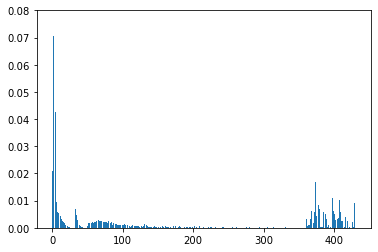

In [20]:
#Get importance of features
importance = rf_clf.feature_importances_

# Output importances 
imp_list = []
for i,v in enumerate(importance):
    imp_list.append((i, v))
sorted_list = sorted(imp_list, key=lambda x: x[1], reverse=True)
print('The top 10 Feature importances are:' '\n')
for f, i in sorted_list[:10]:
    print(f'{X_train.columns[f]}, Score: {round(i, 3)}')
    
# Plot importances:
plt.bar([x for x in range(len(importance))], importance)
plt.ylim(0, 0.08)
plt.show()

Text(0, 0.5, 'Feature Importance Value')

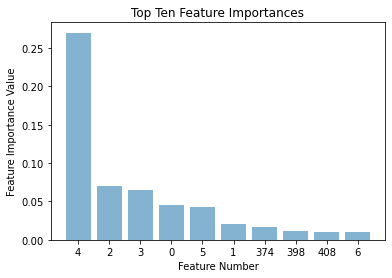

In [33]:
# Plot top ten importances
plt.bar(range(1, 11), [x[1] for x in sorted_list[:10]], 
             tick_label=[x[0] for x in sorted_list[:10]], 
             color = (0.2,0.5,0.7,0.6))

plt.title('Top Ten Feature Importances')
plt.xlabel('Feature Number')
plt.ylabel('Feature Importance Value')

## 7.0 Threshold Selection

In [65]:
# Predict probabilities from optimal model:

optimal_model = grid_search.best_estimator_

probas = optimal_model.predict_proba(X_train)

y_prob = cross_val_predict(optimal_model, X_train, y_train,method='predict_proba', cv=3)[:,1]

In [77]:
# Obtain our False positive rate and True positive rate as well as our Thresholds:
fpr,tpr,threshold = roc_curve(y_train, y_prob)

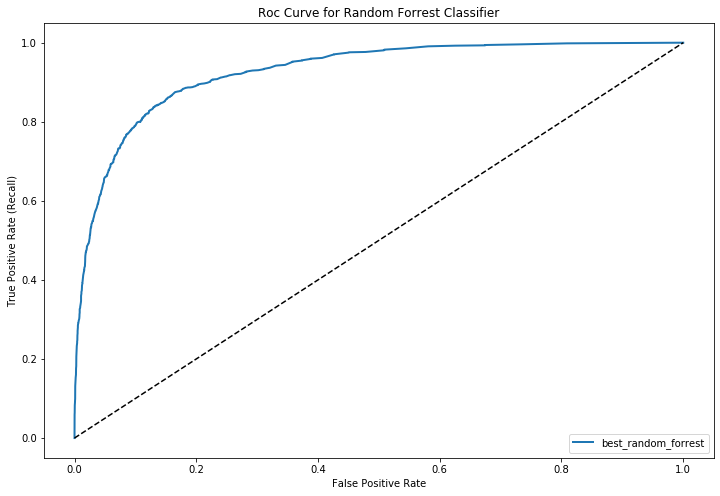

In [78]:
def plot_roc_curve(fpr, tpr, label=None):
    fig = plt.figure(figsize=(12,8))
    plt.plot(fpr,tpr,linewidth= 2, label=label)
    plt.plot([0,1], [0,1],'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('Roc Curve for Random Forrest Classifier')
    plt.legend(loc=4)

plot_roc_curve(fpr, tpr, label='best_random_forrest')
plt.show()

In [82]:
# obtain confusion matrix values (TP, FP, TN, FN):
tn, fp, fn, tp = confusion_matrix(y_train, y_train_rf_predict).ravel()

# Define Costs for Threshold Object Function and m values:

cfp = 150
ctn = 0
cfn = 200
ctp = -50

# Define Prevalence (actual positives/all positives)
prevalence = (tp + fn)/(tp+tn+fn+fp)

#Metz's m:
m = ((1 - prevalence)/prevalence)*((cfp - ctn)/(cfn - ctp))

# Iterate through thresholds from roc_curve to calculate best objective funtion (fm)
best_threshold = 0
diff = 0
for i in range(len(threshold)):
    temp = tpr[i]-(m*fpr[i])
    if temp>diff:
        diff = temp
        best_threshold = threshold[i]
print(best_threshold)

0.43142857142857144


In [85]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    fig = plt.figure(figsize=(12,8))
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precisions')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Thresholds')
    plt.ylabel("Score")
    plt.title('Precision/Recall Trade-off')
    plt.legend(loc='center right')

In [86]:
precisions, recalls, thresholds = precision_recall_curve(y_train, y_prob)

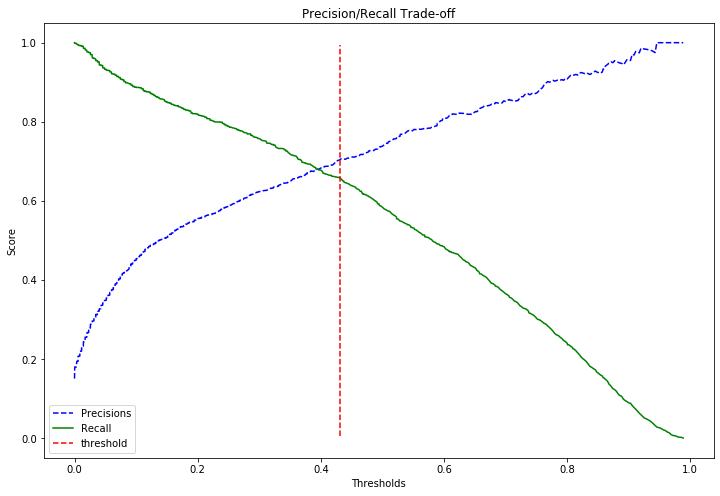

In [87]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.axvline(best_threshold, c='red', linestyle='--', label='threshold', ymax=0.95, ymin=0.05)
plt.legend()
plt.show()

As we see from the graph our threshold given the costs of each outcome is very close to the point where Precisions and Recall intersect.

## 8. Testing our Model

In [92]:
y_probs = optimal_model.predict_proba(X_test)[:,1]
predictions = (y_probs > best_threshold)
cm  = confusion_matrix(y_test, predictions)

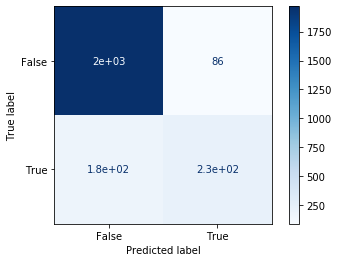

[[1969   86]
 [ 181  230]]


In [94]:
cm_plot = plot_confusion_matrix(optimal_model,X_test, y_test, cmap=plt.cm.Blues)
plt.show()
print(cm_plot.confusion_matrix)

Our model performs okay on test data.

In [97]:
prec = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
print(f'Precision score: {prec}\nRecall score: {recall}')

Precision score: 0.6983695652173914
Recall score: 0.6253041362530414


#  9. Conclusions:
There was a slight increase in model performance when using ensemble models (Random Forest) over Logistic Regression. The Grid Search Parameter optimsation was paramount in obtaining the highest roc_auc score in our random forest model

Here are the top ten feature importances
- Page Value was the most important feature according to the random forest model. It represents "the average value for a page that a user visited before landing on the goal page or completing an Ecommerce transaction (or both)."
- Product related duration was second most important and represents the duration of time spent on product related pages.
- Exit rate was third most important : "For all pageviews to the page, Exit Rate is the percentage that were the last in the session".  

![image](https://user-images.githubusercontent.com/40424244/94347784-1b838880-002f-11eb-885e-a8c5630badcf.png)

A Key component of our model was incoroporating the costs (penalties for getting predictions wrong or right) Once we selected the threshold (0.43) that took those costs into account we were able to obtain : a Precision score = 0.7 and Recall score = 0.63

# 10. Recommendations:

Feature selection could be implemented at some stage to reduce dimensionality and allow the model to work with more relevant data as an input. 
Only 9 of the 400+ features had an importance score of over 0.1

Based on the model performance we can go ahead and provide the feature engineer team with the data needed to build a chat box model. The Chat Box will certainly benefit from the results of this model but work can be done to increase the model performance.

Feedback to the team can be provided regarding the most important features according to the model. Specifically 'Page Values', 'Exit Rate' and 'Product Related Duration' among a few others would be worth considering to reverse engineer in pursuit of optimising the website and thus increasing the revenue for 'DataScienceDeals.com'